In [1]:
import pickle 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def ass_info(week_assignments):
    over_ass = 0
    empty = 0
    lawyers = set()
    for ass in week_assignments:
        lawyers.update(ass)
        if len(ass) > 1:
            over_ass += len(ass) - 1
        elif len(ass) == 0:
            empty += 1
    return len(lawyers), over_ass, empty

def get_load(week):
    return sum(map(lambda x: x[0], week))

In [3]:
def get_data(assignments, spr, sr, lawyers_time, sa, weeks):
    greedy_fos = {}
    greedy_pfos = {}
    greedy_ass = {}
    saa_fos = {}
    saa_pfos = {}
    saa_ass = {}
    services = {}
    mode1 = "saa"
    mode2 = "greedy"


    for rate in assignments:
        for lamb in assignments[rate]:
            saa_sr = sr[rate][lamb][mode1]
            saa_fo = {week: sum(ratings) for week, ratings in saa_sr.items()}
            saa_fo = np.cumsum(list(saa_fo.values()))

            greedy_sr = sr[rate][lamb][mode2]
            greedy_fo = {week: sum(ratings) for week, ratings in greedy_sr.items()}
            greedy_fo = np.cumsum(list(greedy_fo.values()))


            saa_spr = spr[rate][lamb][mode1]
            saa_penalized_fo = {week: sum(ratings) for week, ratings in saa_spr.items()}
            saa_penalized_fo = np.cumsum(list(saa_penalized_fo.values()))

            greedy_spr = spr[rate][lamb][mode2]
            greedy_penalized_fo = {week: sum(ratings) for week, ratings in greedy_spr.items()}
            greedy_penalized_fo = np.cumsum(list(greedy_penalized_fo.values()))


            saa_assignment = assignments[rate][lamb][saa]
            greedy_assignment = assignments[rate][lamb][greedy]
            weeks = list(assignments[rate][lamb][mode1].keys())
            info_per_week = np.array([(len(saa_assignment[week]), 
                             get_load(sa[rate][lamb][mode1][week])) for week in weeks])
            greedy_per_week = np.array([ass_info(greedy_assignment[week]) for week in weeks])
            saa_per_week = np.array([ass_info(saa_assignment[week]) for week in weeks])


            greedy_fos[(rate, lamb)] = greedy_fo
            greedy_pfos[(rate, lamb)] = greedy_penalized_fo
            greedy_ass[(rate, lamb)] = greedy_per_week
            saa_fos[(rate, lamb)] = saa_fo
            saa_pfos[(rate, lamb)] = saa_penalized_fo
            saa_ass[(rate, lamb)] = saa_per_week
            services[(rate, lamb)] = info_per_week
    return (greedy_fos, greedy_pfos, greedy_ass), (saa_fos, saa_pfos, saa_ass), services

In [4]:
def create_tables(rate, lambs, weeks, solvers, services, saa_ass, greedy_ass):
    columns = [f"w{week}" for week in weeks]
    index = pd.MultiIndex.from_product([
        solvers,
        ["abogados asignados", "sobreasignaciones", "servicios botados"]
    ])

    index = pd.MultiIndex.from_tuples([("servicios totales", ""), ("tiempo demandado", "")]
                                      + list(index))

    table = pd.DataFrame(columns=columns, index=index)
    table.loc[("servicios totales", "")] = services[rate, lambs[0]][:, 0]
    table.loc[("tiempo demandado", "")] = services[rate, lambs[0]][:, 1]

    for lamb in lambs:
        key1 = f"saa-{lamb}"
        #table.loc[(key1, "rating"), :] = np.round(saa_fos[rate, lamb], 2)
        #table.loc[(key1, "penalized rating"), :] = np.round(saa_pfos[rate, lamb], 2)
        table.loc[(key1, "abogados asignados"), :] = saa_ass[rate, lamb][:, 0]
        table.loc[(key1, "sobreasignaciones"), :] = saa_ass[rate, lamb][:, 1]
        table.loc[(key1, "servicios botados"), :] = saa_ass[rate, lamb][:, 2]

    #table.loc[("greedy", "rating"), :] = np.round(saa_fos[rate, lamb], 2)
    #table.loc[("greedy", "penalized rating"), :] = np.round(greedy_pfos[rate, lamb], 2)
    table.loc[("greedy", "abogados asignados"), :] = greedy_ass[rate, lamb][:, 0]
    table.loc[("greedy", "sobreasignaciones"), :] = greedy_ass[rate, lamb][:, 1]
    table.loc[("greedy", "servicios botados"), :] = greedy_ass[rate, lamb][:, 2]
    table.insert(loc=len(weeks), column="total", value=table.sum(axis=1))

    h = table.iloc[[0, 1], :]   

    t1 = table.iloc[2:, :].loc[(slice(None), "servicios botados"), :].swaplevel(0, 1, axis=0)
    t1 = h.append(t1) 

    t2 = table.iloc[2:, :].loc[(slice(None), "abogados asignados"), :].swaplevel(0, 1, axis=0)
    t2 = h.append(t2)

    t3 = table.iloc[2:, :].loc[(slice(None), "sobreasignaciones"), :].swaplevel(0, 1, axis=0)
    t3 = h.append(t3)
    return table, t1, t2, t3

# 130 percent #

In [5]:
with open('results/130percent/assignments.pickle', 'rb') as file:
    assignments = pickle.load(file)
    
with open('results/130percent/spr.pickle', 'rb') as file:
    spr = pickle.load(file)

with open('results/130percent/sr.pickle', 'rb') as file:
    sr = pickle.load(file)
    
with open('results/130percent/time_lawyers.pickle', 'rb') as file:
    lawyers_time = pickle.load(file)
    
with open('results/130percent/sa.pickle', 'rb') as file:
    sa = pickle.load(file)
    
mode1, mode2 = 'saa', 'greedy'

In [6]:
rates = list(spr.keys())
lambs = list(spr[1.25].keys())
saa, greedy = list(spr[1.25][0.2].keys())
weeks = list(spr[1.25][0.2]['saa'].keys())

print(rates)
print(lambs)
print(saa, greedy)
print(weeks)

[1.25, 4]
[0.2, 0.5, 0.8]
saa greedy
[1, 2, 4, 5, 8, 9, 10, 11, 12, 15]


In [7]:
greedy_info, saa_info, services = get_data(assignments, spr, sr, lawyers_time, sa, weeks)
greedy_fos, greedy_pfos, greedy_ass = greedy_info
saa_fos, saa_pfos, saa_ass = saa_info

### rate = 1.25 ###

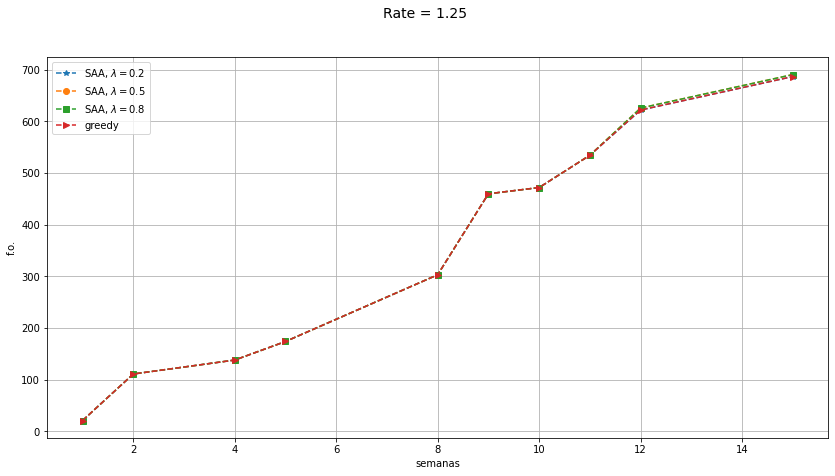

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])

ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

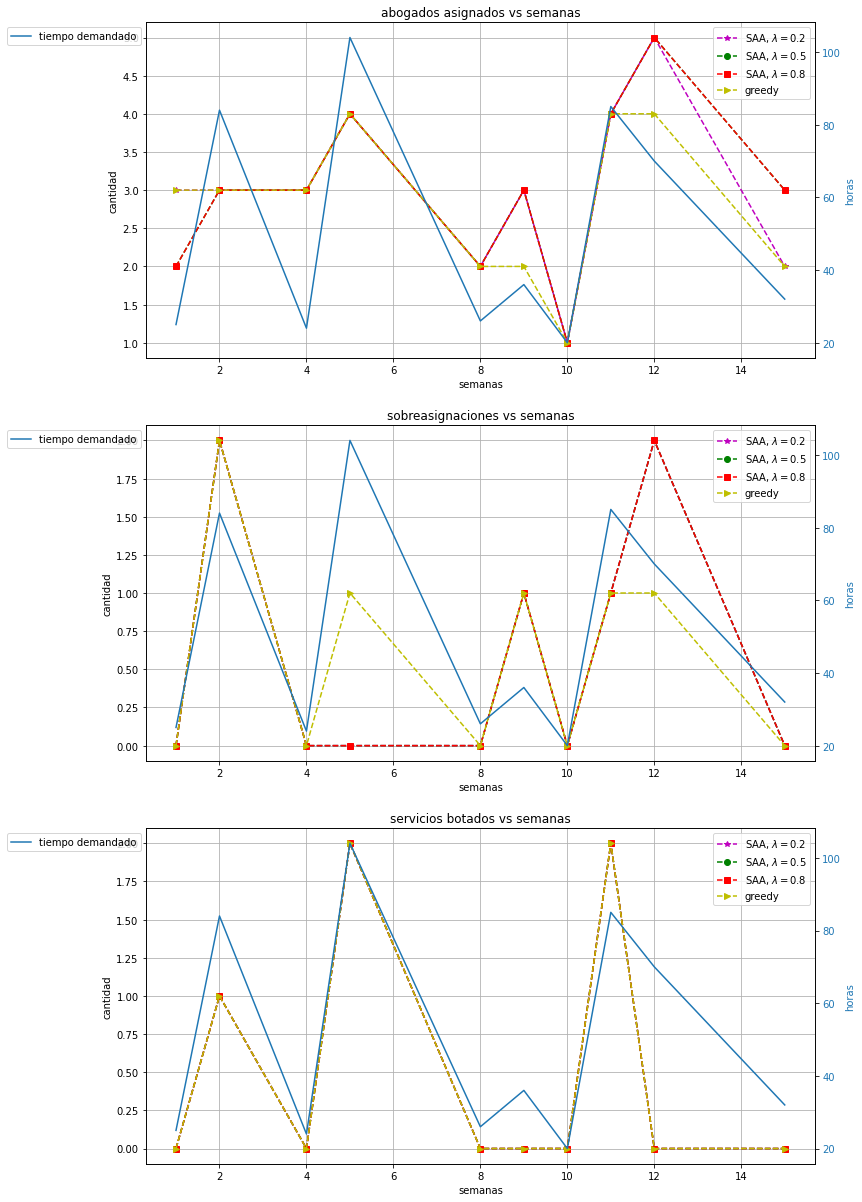

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [10]:
solvers = ["greedy", "saa-0.2", "saa-0.5", "saa-0.8"]
table, t1, t2, t3 = create_tables(rate, lambs, weeks, solvers, 
                                  services, saa_ass, greedy_ass)

In [11]:
table

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  \
servicios totales                      3   3   3    6   2   2   1   5   4   3   
tiempo demandado                      25  84  24  104  26  36  20  85  70  32   
greedy            abogados asignados   3   3   3    4   2   2   1   4   4   2   
                  sobreasignaciones    0   2   0    1   0   1   0   1   1   0   
                  servicios botados    0   1   0    2   0   0   0   2   0   0   
saa-0.2           abogados asignados   3   3   3    4   2   3   1   4   5   2   
                  sobreasignaciones    0   2   0    0   0   1   0   1   2   0   
                  servicios botados    0   1   0    2   0   0   0   2   0   0   
saa-0.5           abogados asignados   2   3   3    4   2   3   1   4   5   3   
                  sobreasignaciones    0   2   0    0   0   1   0   1   2   0   
                  servicios botados    0   1   0    2   0   0   0   2   0   0   
saa-0.8           abogados asignados   2   3   3    4   2   3   1   4   5   3   
                  sobreasignaciones    0   2   0    0   0   1   0   1   2   0   
                  servicios botados    0   1   0    2   0   0   0   2   0   0   

                                      total  
servicios totales                      32.0  
tiempo demandado                      506.0  
greedy            abogados asignados   28.0  
                  sobreasignaciones     6.0  
                  servicios botados     5.0  
saa-0.2           abogados asignados   30.0  
                  sobreasignaciones     6.0  
                  servicios botados     5.0  
saa-0.5           abogados asignados   30.0  
                  sobreasignaciones     6.0  
                  servicios botados     5.0  
saa-0.8           abogados asignados   30.0  
                  sobreasignaciones     6.0  
                  servicios botados     5.0

In [12]:
t1

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales           3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado           25  84  24  104  26  36  20  85  70  32  506.0
servicios botados greedy    0   1   0    2   0   0   0   2   0   0    5.0
                  saa-0.2   0   1   0    2   0   0   0   2   0   0    5.0
                  saa-0.5   0   1   0    2   0   0   0   2   0   0    5.0
                  saa-0.8   0   1   0    2   0   0   0   2   0   0    5.0

In [13]:
t2

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales            3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado            25  84  24  104  26  36  20  85  70  32  506.0
abogados asignados greedy    3   3   3    4   2   2   1   4   4   2   28.0
                   saa-0.2   3   3   3    4   2   3   1   4   5   2   30.0
                   saa-0.5   2   3   3    4   2   3   1   4   5   3   30.0
                   saa-0.8   2   3   3    4   2   3   1   4   5   3   30.0

In [14]:
t3

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales           3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado           25  84  24  104  26  36  20  85  70  32  506.0
sobreasignaciones greedy    0   2   0    1   0   1   0   1   1   0    6.0
                  saa-0.2   0   2   0    0   0   1   0   1   2   0    6.0
                  saa-0.5   0   2   0    0   0   1   0   1   2   0    6.0
                  saa-0.8   0   2   0    0   0   1   0   1   2   0    6.0

### rate = 4 ###

In [15]:
!ls ..

Informe_V01.pdf asignaciones    modelo          simulationv2
README.md       datos           simulation


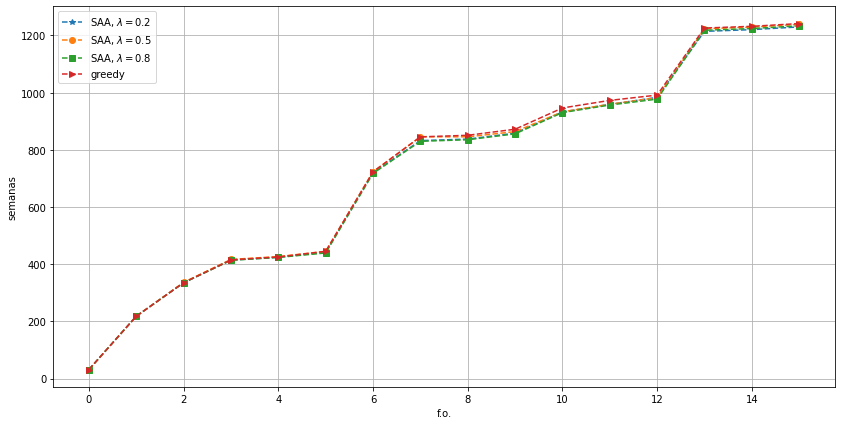

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())

symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])

ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 

ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_ylabel('semanas')
ax1.set_xlabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_ylabel('semanas')
ax1.set_xlabel('f.o.')

plt.show()

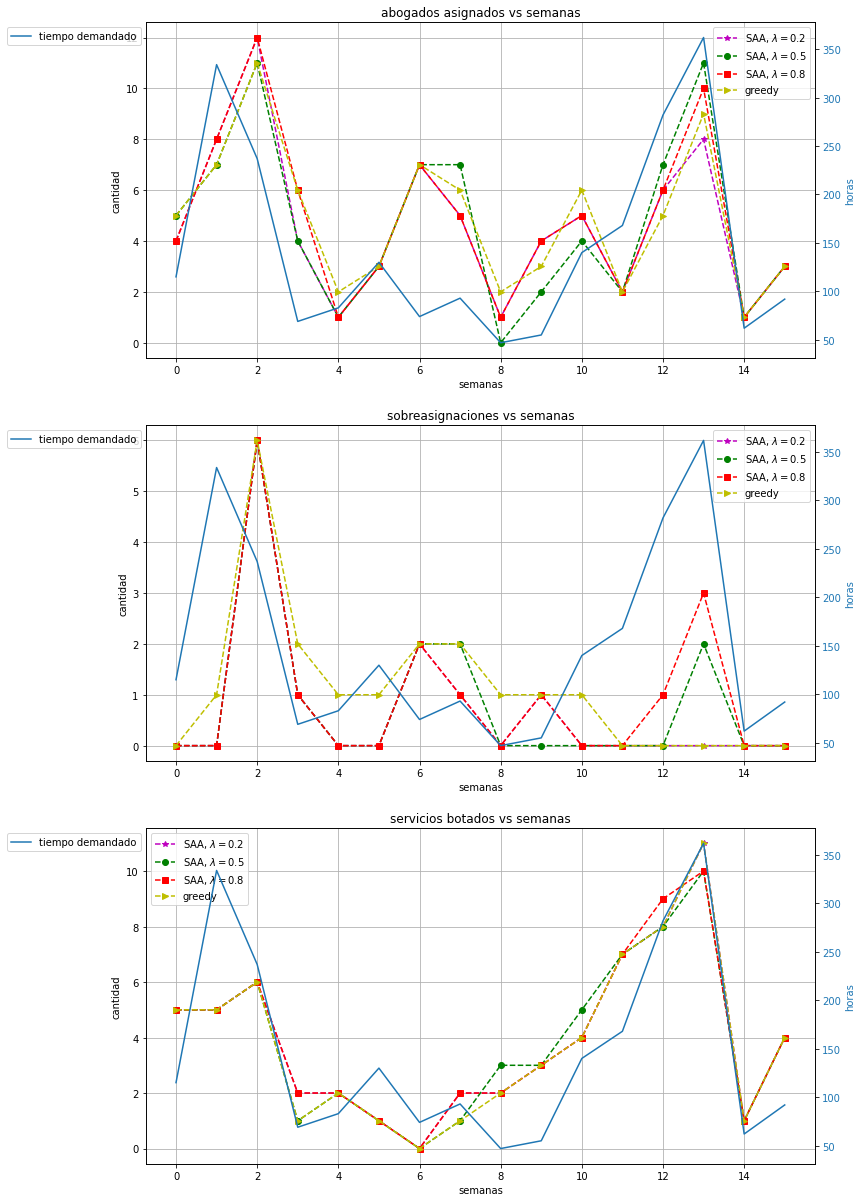

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [18]:
solvers = ["greedy", "saa-0.2", "saa-0.5", "saa-0.8"]
table, t1, t2, t3 = create_tables(rate, lambs, weeks, solvers, 
                                  services, saa_ass, greedy_ass)

table

w0   w1   w2  w3  w4   w5  w6  w7  w8  \
servicios totales                      10   16   14   8   3    4   6   6   3   
tiempo demandado                      115  334  237  69  83  130  74  93  47   
greedy            abogados asignados    5    7   11   6   2    3   7   6   2   
                  sobreasignaciones     0    1    6   2   1    1   2   2   1   
                  servicios botados     5    5    6   1   2    1   0   1   2   
saa-0.2           abogados asignados    4    8   12   4   1    3   7   5   1   
                  sobreasignaciones     0    0    6   1   0    0   2   1   0   
                  servicios botados     5    5    6   2   2    1   0   2   2   
saa-0.5           abogados asignados    5    7   11   4   1    3   7   7   0   
                  sobreasignaciones     0    0    6   1   0    0   2   2   0   
                  servicios botados     5    5    6   1   2    1   0   1   3   
saa-0.8           abogados asignados    4    8   12   6   1    3   7   5   1   
                  sobreasignaciones     0    0    6   1   0    0   2   1   0   
                  servicios botados     5    5    6   2   2    1   0   2   2   

                                      w9  w10  w11  w12  w13 w14 w15   total  
servicios totales                      7   10   10   16   23   2   7   145.0  
tiempo demandado                      55  140  168  282  362  62  92  2343.0  
greedy            abogados asignados   3    6    2    5    9   1   3    78.0  
                  sobreasignaciones    1    1    0    0    0   0   0    18.0  
                  servicios botados    3    4    7    8   11   1   4    61.0  
saa-0.2           abogados asignados   4    5    2    6    8   1   3    74.0  
                  sobreasignaciones    1    0    0    0    0   0   0    11.0  
                  servicios botados    3    4    7    8   11   1   4    63.0  
saa-0.5           abogados asignados   2    4    2    7   11   1   3    75.0  
                  sobreasignaciones    0    0    0    0    2   0   0    13.0  
                  servicios botados    3    5    7    8   10   1   4    62.0  
saa-0.8           abogados asignados   4    5    2    6   10   1   3    78.0  
                  sobreasignaciones    1    0    0    1    3   0   0    15.0  
                  servicios botados    3    4    7    9   10   1   4    63.0

In [19]:
t1

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales           10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado           115  334  237  69  83  130  74  93  47  55  140   
servicios botados greedy     5    5    6   1   2    1   0   1   2   3    4   
                  saa-0.2    5    5    6   2   2    1   0   2   2   3    4   
                  saa-0.5    5    5    6   1   2    1   0   1   3   3    5   
                  saa-0.8    5    5    6   2   2    1   0   2   2   3    4   

                           w11  w12  w13 w14 w15   total  
servicios totales           10   16   23   2   7   145.0  
tiempo demandado           168  282  362  62  92  2343.0  
servicios botados greedy     7    8   11   1   4    61.0  
                  saa-0.2    7    8   11   1   4    63.0  
                  saa-0.5    7    8   10   1   4    62.0  
                  saa-0.8    7    9   10   1   4    63.0

In [20]:
t2

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales            10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado            115  334  237  69  83  130  74  93  47  55  140   
abogados asignados greedy     5    7   11   6   2    3   7   6   2   3    6   
                   saa-0.2    4    8   12   4   1    3   7   5   1   4    5   
                   saa-0.5    5    7   11   4   1    3   7   7   0   2    4   
                   saa-0.8    4    8   12   6   1    3   7   5   1   4    5   

                            w11  w12  w13 w14 w15   total  
servicios totales            10   16   23   2   7   145.0  
tiempo demandado            168  282  362  62  92  2343.0  
abogados asignados greedy     2    5    9   1   3    78.0  
                   saa-0.2    2    6    8   1   3    74.0  
                   saa-0.5    2    7   11   1   3    75.0  
                   saa-0.8    2    6   10   1   3    78.0

In [21]:
t3

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales           10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado           115  334  237  69  83  130  74  93  47  55  140   
sobreasignaciones greedy     0    1    6   2   1    1   2   2   1   1    1   
                  saa-0.2    0    0    6   1   0    0   2   1   0   1    0   
                  saa-0.5    0    0    6   1   0    0   2   2   0   0    0   
                  saa-0.8    0    0    6   1   0    0   2   1   0   1    0   

                           w11  w12  w13 w14 w15   total  
servicios totales           10   16   23   2   7   145.0  
tiempo demandado           168  282  362  62  92  2343.0  
sobreasignaciones greedy     0    0    0   0   0    18.0  
                  saa-0.2    0    0    0   0   0    11.0  
                  saa-0.5    0    0    2   0   0    13.0  
                  saa-0.8    0    1    3   0   0    15.0

# 40 #

In [22]:
with open('results/40/assignments.pickle', 'rb') as file:
    assignments = pickle.load(file)
    
with open('results/40/spr.pickle', 'rb') as file:
    spr = pickle.load(file)

with open('results/40/sr.pickle', 'rb') as file:
    sr = pickle.load(file)
    
with open('results/40/time_lawyers.pickle', 'rb') as file:
    lawyers_time = pickle.load(file)
    
with open('results/40/sa.pickle', 'rb') as file:
    sa = pickle.load(file)
    
mode1, mode2 = 'saa', 'greedy'

In [23]:
weeks = list(spr[4][0.2]['saa'].keys())
saa='saa'
greedy='greedy'
greedy_info, saa_info, services = get_data(assignments, spr, sr, lawyers_time, sa, weeks)
greedy_fos, greedy_pfos, greedy_ass = greedy_info
saa_fos, saa_pfos, saa_ass = saa_info

### rate = 1.25 ###

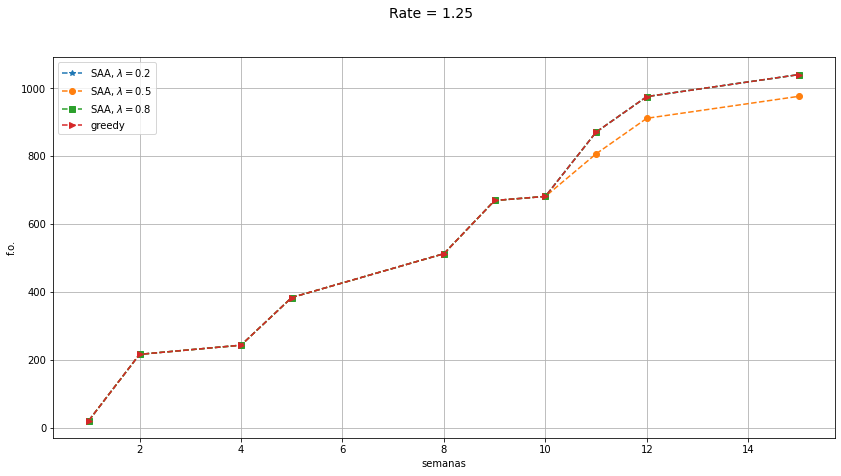

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])

ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

fig.suptitle(f"Rate = {rate}", fontsize=14)
plt.show()

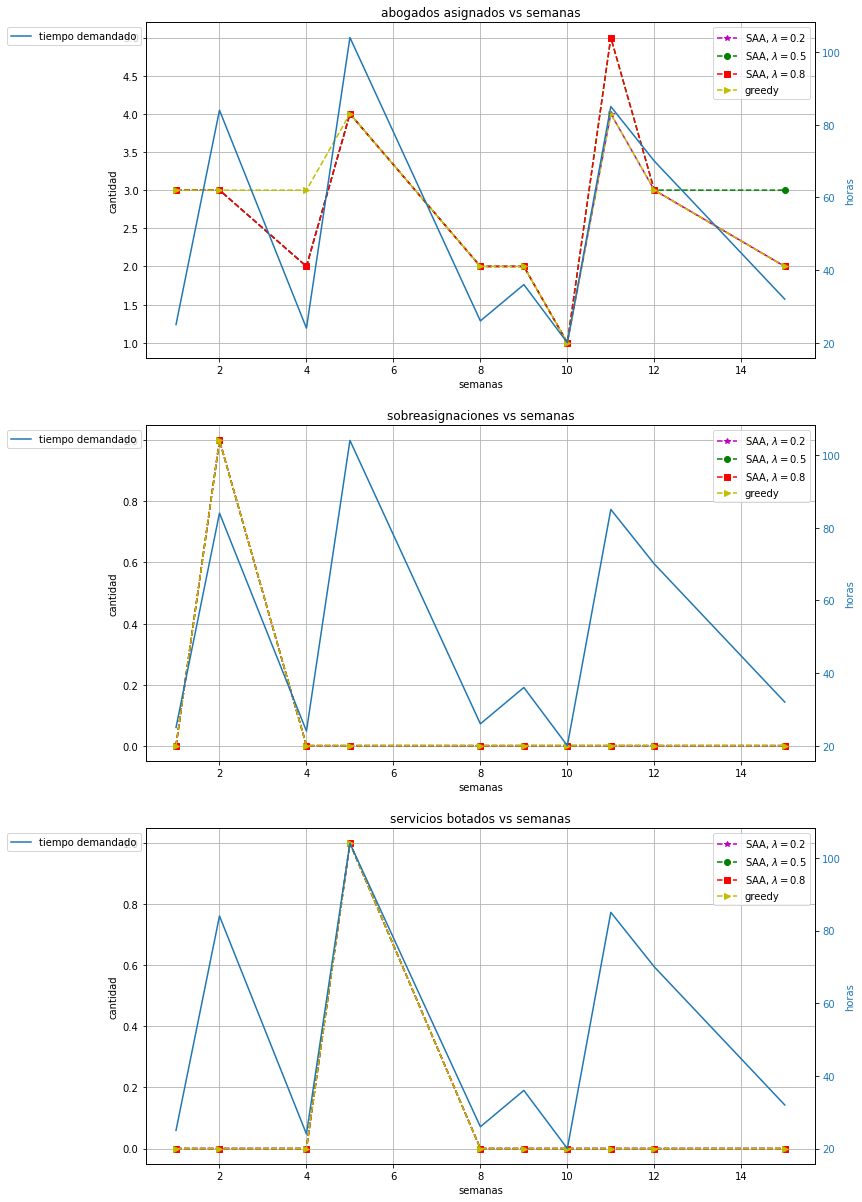

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 1.25
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [26]:
solvers = ["greedy", "saa-0.2", "saa-0.5", "saa-0.8"]
table, t1, t2, t3 = create_tables(rate, lambs, weeks, solvers, 
                                  services, saa_ass, greedy_ass)
table

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  \
servicios totales                      3   3   3    6   2   2   1   5   4   3   
tiempo demandado                      25  84  24  104  26  36  20  85  70  32   
greedy            abogados asignados   3   3   3    4   2   2   1   4   3   2   
                  sobreasignaciones    0   1   0    0   0   0   0   0   0   0   
                  servicios botados    0   0   0    1   0   0   0   0   0   0   
saa-0.2           abogados asignados   3   3   2    4   2   2   1   4   3   2   
                  sobreasignaciones    0   1   0    0   0   0   0   0   0   0   
                  servicios botados    0   0   0    1   0   0   0   0   0   0   
saa-0.5           abogados asignados   3   3   2    4   2   2   1   5   3   3   
                  sobreasignaciones    0   1   0    0   0   0   0   0   0   0   
                  servicios botados    0   0   0    1   0   0   0   0   0   0   
saa-0.8           abogados asignados   3   3   2    4   2   2   1   5   3   2   
                  sobreasignaciones    0   1   0    0   0   0   0   0   0   0   
                  servicios botados    0   0   0    1   0   0   0   0   0   0   

                                      total  
servicios totales                      32.0  
tiempo demandado                      506.0  
greedy            abogados asignados   27.0  
                  sobreasignaciones     1.0  
                  servicios botados     1.0  
saa-0.2           abogados asignados   26.0  
                  sobreasignaciones     1.0  
                  servicios botados     1.0  
saa-0.5           abogados asignados   28.0  
                  sobreasignaciones     1.0  
                  servicios botados     1.0  
saa-0.8           abogados asignados   27.0  
                  sobreasignaciones     1.0  
                  servicios botados     1.0

In [27]:
t1

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales           3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado           25  84  24  104  26  36  20  85  70  32  506.0
servicios botados greedy    0   0   0    1   0   0   0   0   0   0    1.0
                  saa-0.2   0   0   0    1   0   0   0   0   0   0    1.0
                  saa-0.5   0   0   0    1   0   0   0   0   0   0    1.0
                  saa-0.8   0   0   0    1   0   0   0   0   0   0    1.0

In [28]:
t2

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales            3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado            25  84  24  104  26  36  20  85  70  32  506.0
abogados asignados greedy    3   3   3    4   2   2   1   4   3   2   27.0
                   saa-0.2   3   3   2    4   2   2   1   4   3   2   26.0
                   saa-0.5   3   3   2    4   2   2   1   5   3   3   28.0
                   saa-0.8   3   3   2    4   2   2   1   5   3   2   27.0

In [29]:
t3

w1  w2  w4   w5  w8  w9 w10 w11 w12 w15  total
servicios totales           3   3   3    6   2   2   1   5   4   3   32.0
tiempo demandado           25  84  24  104  26  36  20  85  70  32  506.0
sobreasignaciones greedy    0   1   0    0   0   0   0   0   0   0    1.0
                  saa-0.2   0   1   0    0   0   0   0   0   0   0    1.0
                  saa-0.5   0   1   0    0   0   0   0   0   0   0    1.0
                  saa-0.8   0   1   0    0   0   0   0   0   0   0    1.0

### rate = 4 ###

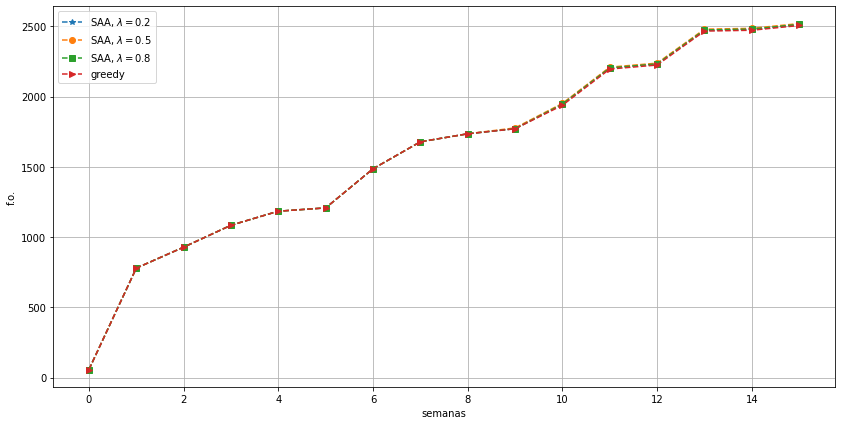

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 7))

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())

symbols = ["--*", "--o", "--s"]
for i, lamb in enumerate(lambs):
    ax1.plot(weeks, saa_fos[rate, lamb], symbols[i])

ax1.plot(weeks, greedy_fos[rate, lamb], "-->") 


ax1.grid()
ax1.legend(list(map(lambda x: "SAA " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA "+  r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.legend(list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + ["greedy"])
ax1.set_xlabel('semanas')
ax1.set_ylabel('f.o.')

plt.show()

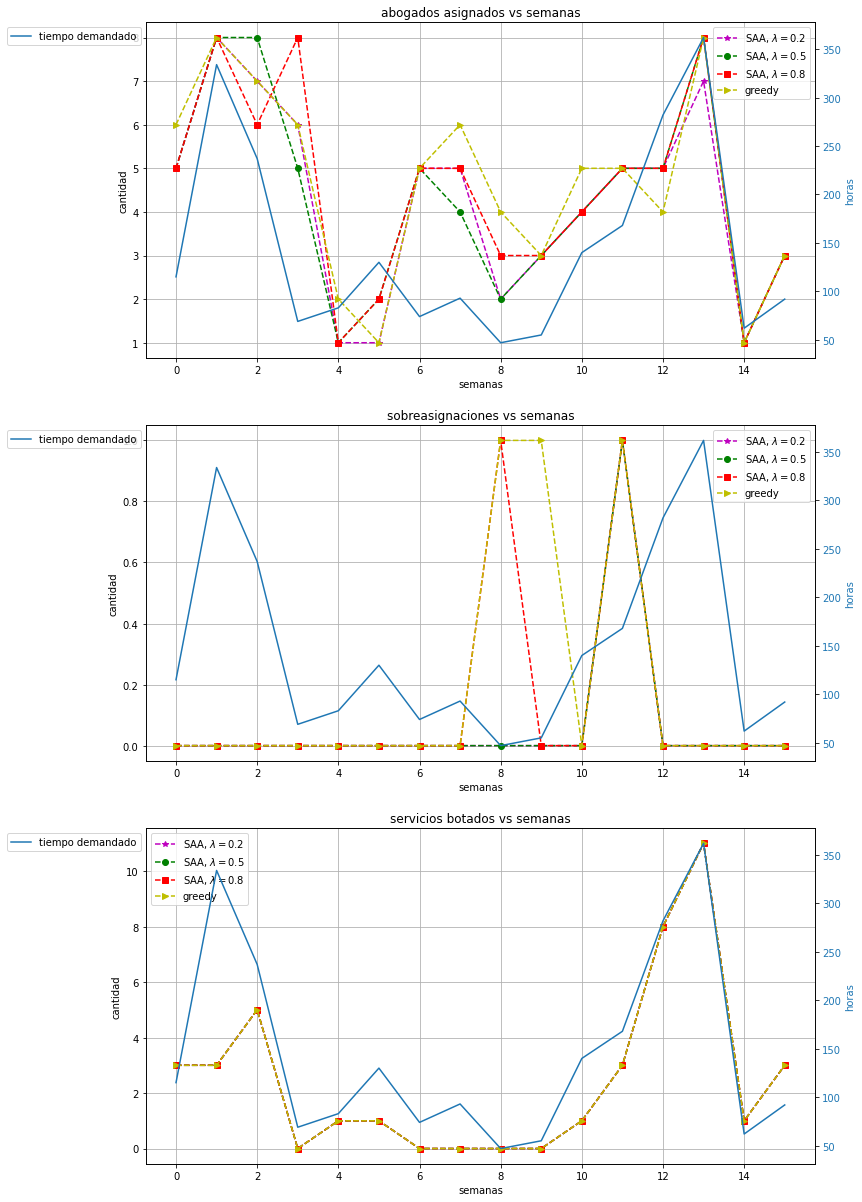

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 21))

axs = [ax1, ax2, ax3]
twins = [ax1.twinx(), ax2.twinx(), ax3.twinx()]

rate = 4
weeks = list(spr[rate][0.2]['saa'].keys())


symbols = ["--*", "--o", "--s"]
colors = ["m", "g", "r"]
legend = (list(map(lambda x: "SAA, " + r"$\lambda=$" + str(x), lambs)) + 
            ["greedy", "servicios totales"])
labels = ["abogados asignados", "sobreasignaciones", "servicios botados"]

for j in range(3): # se recorren los 3 dato
    for i, lamb in enumerate(lambs):
        axs[j].plot(weeks, saa_ass[rate, lamb][:, j], symbols[i], color=colors[i])

    axs[j].plot(weeks, greedy_ass[rate, lamb][:, j], "-->", color="y") 
    #axs[j].scatter(weeks, services[rate, lamb][:, 0], marker="o", color="black")
    axs[j].grid()
    axs[j].legend(legend)
    axs[j].set_ylabel('cantidad')
    axs[j].set_xlabel('semanas')
    axs[j].set(title=f"{labels[j]} vs semanas")

    color = 'tab:blue'
    twins[j].set_ylabel('horas', color=color)  # we already handled the x-label with ax1
    twins[j].plot(weeks, services[rate, lamb][:, 1], color=color)
    twins[j].tick_params(axis='y', labelcolor=color)
    twins[j].legend(["tiempo demandado"], bbox_to_anchor=[0, 1])
    
plt.show()

In [32]:
solvers = ["greedy", "saa-0.2", "saa-0.5", "saa-0.8"]
table, t1, t2, t3 = create_tables(rate, lambs, weeks, solvers, 
                                  services, saa_ass, greedy_ass)
table

w0   w1   w2  w3  w4   w5  w6  w7  w8  \
servicios totales                      10   16   14   8   3    4   6   6   3   
tiempo demandado                      115  334  237  69  83  130  74  93  47   
greedy            abogados asignados    6    8    7   6   2    1   5   6   4   
                  sobreasignaciones     0    0    0   0   0    0   0   0   1   
                  servicios botados     3    3    5   0   1    1   0   0   0   
saa-0.2           abogados asignados    5    8    7   6   1    1   5   5   2   
                  sobreasignaciones     0    0    0   0   0    0   0   0   0   
                  servicios botados     3    3    5   0   1    1   0   0   0   
saa-0.5           abogados asignados    5    8    8   5   1    2   5   4   2   
                  sobreasignaciones     0    0    0   0   0    0   0   0   0   
                  servicios botados     3    3    5   0   1    1   0   0   0   
saa-0.8           abogados asignados    5    8    6   8   1    2   5   5   3   
                  sobreasignaciones     0    0    0   0   0    0   0   0   1   
                  servicios botados     3    3    5   0   1    1   0   0   0   

                                      w9  w10  w11  w12  w13 w14 w15   total  
servicios totales                      7   10   10   16   23   2   7   145.0  
tiempo demandado                      55  140  168  282  362  62  92  2343.0  
greedy            abogados asignados   3    5    5    4    8   1   3    74.0  
                  sobreasignaciones    1    0    1    0    0   0   0     3.0  
                  servicios botados    0    1    3    8   11   1   3    40.0  
saa-0.2           abogados asignados   3    4    5    5    7   1   3    68.0  
                  sobreasignaciones    0    0    1    0    0   0   0     1.0  
                  servicios botados    0    1    3    8   11   1   3    40.0  
saa-0.5           abogados asignados   3    4    5    5    8   1   3    69.0  
                  sobreasignaciones    0    0    1    0    0   0   0     1.0  
                  servicios botados    0    1    3    8   11   1   3    40.0  
saa-0.8           abogados asignados   3    4    5    5    8   1   3    72.0  
                  sobreasignaciones    0    0    1    0    0   0   0     2.0  
                  servicios botados    0    1    3    8   11   1   3    40.0

In [33]:
t1

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales           10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado           115  334  237  69  83  130  74  93  47  55  140   
servicios botados greedy     3    3    5   0   1    1   0   0   0   0    1   
                  saa-0.2    3    3    5   0   1    1   0   0   0   0    1   
                  saa-0.5    3    3    5   0   1    1   0   0   0   0    1   
                  saa-0.8    3    3    5   0   1    1   0   0   0   0    1   

                           w11  w12  w13 w14 w15   total  
servicios totales           10   16   23   2   7   145.0  
tiempo demandado           168  282  362  62  92  2343.0  
servicios botados greedy     3    8   11   1   3    40.0  
                  saa-0.2    3    8   11   1   3    40.0  
                  saa-0.5    3    8   11   1   3    40.0  
                  saa-0.8    3    8   11   1   3    40.0

In [34]:
t2

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales            10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado            115  334  237  69  83  130  74  93  47  55  140   
abogados asignados greedy     6    8    7   6   2    1   5   6   4   3    5   
                   saa-0.2    5    8    7   6   1    1   5   5   2   3    4   
                   saa-0.5    5    8    8   5   1    2   5   4   2   3    4   
                   saa-0.8    5    8    6   8   1    2   5   5   3   3    4   

                            w11  w12  w13 w14 w15   total  
servicios totales            10   16   23   2   7   145.0  
tiempo demandado            168  282  362  62  92  2343.0  
abogados asignados greedy     5    4    8   1   3    74.0  
                   saa-0.2    5    5    7   1   3    68.0  
                   saa-0.5    5    5    8   1   3    69.0  
                   saa-0.8    5    5    8   1   3    72.0

In [35]:
t3

w0   w1   w2  w3  w4   w5  w6  w7  w8  w9  w10  \
servicios totales           10   16   14   8   3    4   6   6   3   7   10   
tiempo demandado           115  334  237  69  83  130  74  93  47  55  140   
sobreasignaciones greedy     0    0    0   0   0    0   0   0   1   1    0   
                  saa-0.2    0    0    0   0   0    0   0   0   0   0    0   
                  saa-0.5    0    0    0   0   0    0   0   0   0   0    0   
                  saa-0.8    0    0    0   0   0    0   0   0   1   0    0   

                           w11  w12  w13 w14 w15   total  
servicios totales           10   16   23   2   7   145.0  
tiempo demandado           168  282  362  62  92  2343.0  
sobreasignaciones greedy     1    0    0   0   0     3.0  
                  saa-0.2    1    0    0   0   0     1.0  
                  saa-0.5    1    0    0   0   0     1.0  
                  saa-0.8    1    0    0   0   0     2.0

# Análisis de tiempo de abogados #

### rate = 4 ###

In [43]:
rate = 4
L = 23
times = np.ones((len(lambs) + 1, len(weeks) + 1, L)) * 40
print(times[3, 15, 22])

for i, lamb in enumerate(lambs):
    for j, week in enumerate(weeks):
        for l, time in lawyers_time[rate][lamb][saa][week + 1].items():
            times[i, week, l] = min(40, time)
            
for i, week in enumerate(weeks):
    for l, time in lawyers_time[rate][lambs[0]][greedy][week].items():
        times[len(lambs), i, l] = min(40, time)
        
times

40.0


KeyError: 0

In [39]:
lawyers_time[4][0.8][saa].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [40]:
weeks

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [42]:
list(spr[rate][0.8]['saa'].keys())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]